<ipython-input-126-c9a6c3f28eaa>:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


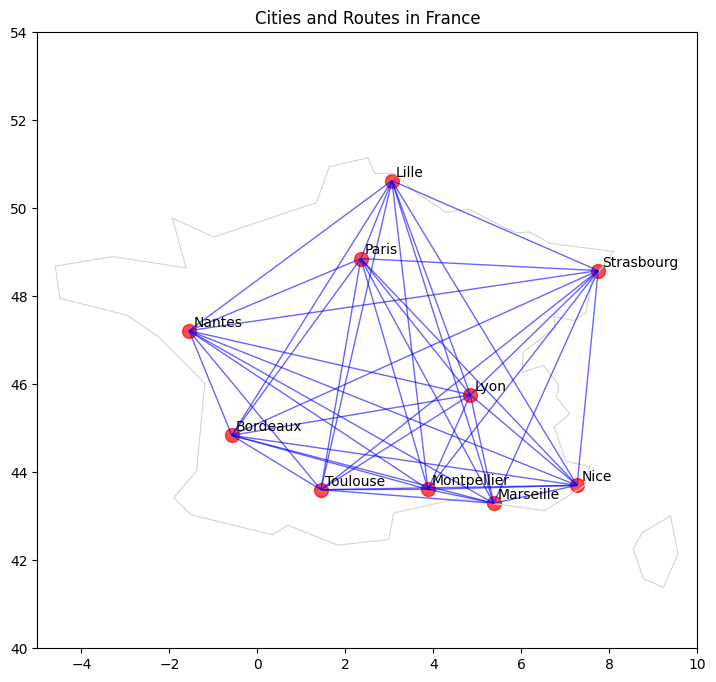

In [ ]:
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

# Set the number of nodes (cities)
num_nodes = 10

# Define the city data
city_data = {
    'city': ['Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice', 'Nantes', 'Montpellier', 'Strasbourg', 'Bordeaux', 'Lille'],
    'lat': [48.8567, 43.2964, 45.7600, 43.6045, 43.7034, 47.2181, 43.6119, 48.5833, 44.8400, 50.6278],
    'lng': [2.3522, 5.3700, 4.8400, 1.4440, 7.2663, -1.5528, 3.8772, 7.7458, -0.5800, 3.0583]
}

# Create a complete graph with num_nodes nodes
G = nx.complete_graph(num_nodes)

# Add nodes to the graph with city names as labels
for i in range(num_nodes):
    G.nodes[i]['city'] = city_data['city'][i]

# Create a GeoDataFrame for the cities with Point geometries
gdf_cities = gpd.GeoDataFrame(city_data, geometry=gpd.points_from_xy(city_data['lng'], city_data['lat']))

# Create a GeoDataFrame for the routes (edges)
routes = []
for edge in G.edges():
    city1 = G.nodes[edge[0]]['city']
    city2 = G.nodes[edge[1]]['city']
    route = LineString([(gdf_cities[gdf_cities['city'] == city1].geometry.x.iloc[0], gdf_cities[gdf_cities['city'] == city1].geometry.y.iloc[0]),
                        (gdf_cities[gdf_cities['city'] == city2].geometry.x.iloc[0], gdf_cities[gdf_cities['city'] == city2].geometry.y.iloc[0])])
    routes.append(route)

gdf_routes = gpd.GeoDataFrame(geometry=routes)

# Create a plot for the map of France
fig, ax = plt.subplots(figsize=(10, 8))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france_shapefile = world[world.name == 'France']
france_shapefile.boundary.plot(ax=ax, color='lightgray', linewidth=0.8)
gdf_cities.plot(ax=ax, marker='o', color='red', markersize=100, alpha=0.7)
gdf_routes.plot(ax=ax, color='blue', linewidth=1, alpha=0.6)

# Add labels for the cities
for x, y, label in zip(gdf_cities.geometry.x, gdf_cities.geometry.y, gdf_cities['city']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='black', fontsize=10)

# Set the axis limits to focus on France
ax.set_xlim(-5, 10)
ax.set_ylim(40, 54)

# Show the plot
plt.title('Cities and Routes in France')
plt.show()


In [ ]:
# Compute the distance and add weight to each edge
from geopy.distance import geodesic
import numpy as np
for edge in G.edges():
    city1 = G.nodes[edge[0]]['city']
    city2 = G.nodes[edge[1]]['city']
    coord1 = (city_data['lat'][city_data['city'].index(city1)], city_data['lng'][city_data['city'].index(city1)])
    coord2 = (city_data['lat'][city_data['city'].index(city2)], city_data['lng'][city_data['city'].index(city2)])
    distance_km = geodesic(coord1, coord2).kilometers
    G.edges[edge]['weight'] = np.round(0.25 * distance_km)

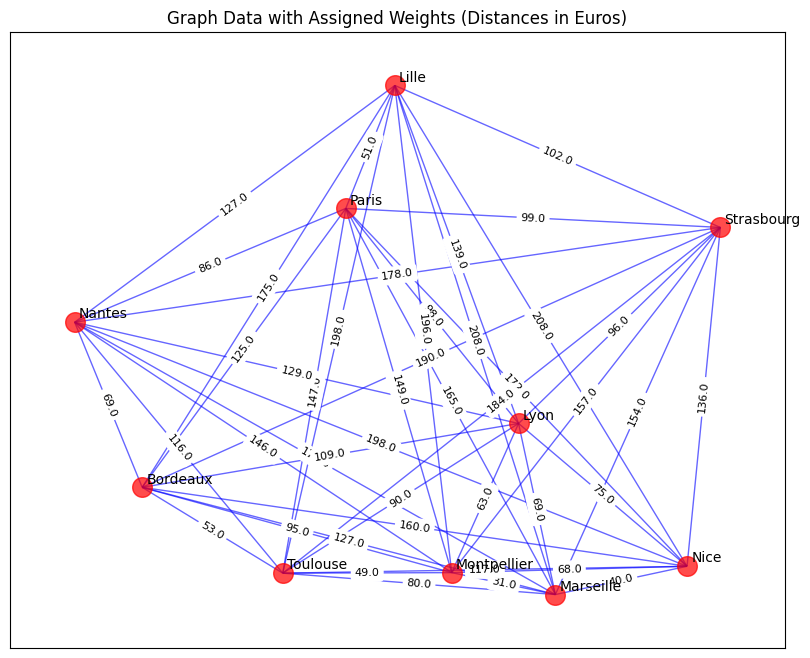

In [ ]:
# Create a plot for the graph data with assigned weights
fig, ax = plt.subplots(figsize=(10, 8))

# Create a GeoDataFrame for the cities with Point geometries
gdf_cities = gpd.GeoDataFrame(city_data, geometry=gpd.points_from_xy(city_data['lng'], city_data['lat']))

# Draw the cities as nodes
pos = {i: (city_data['lng'][i], city_data['lat'][i]) for i in range(num_nodes)}
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='red', alpha=0.7, ax=ax)

# Draw the routes as edges with weights as labels
edges = nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6, width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

# Add labels for the cities
for x, y, label in zip(gdf_cities.geometry.x, gdf_cities.geometry.y, gdf_cities['city']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='black', fontsize=10)

# Set the axis limits to focus on the cities
ax.set_xlim(min(city_data['lng']) - 1, max(city_data['lng']) + 1)
ax.set_ylim(min(city_data['lat']) - 1, max(city_data['lat']) + 1)

# Show the plot
plt.title('Graph Data with Assigned Weights (Distances in Euros)')
plt.axis('equal')
plt.show()

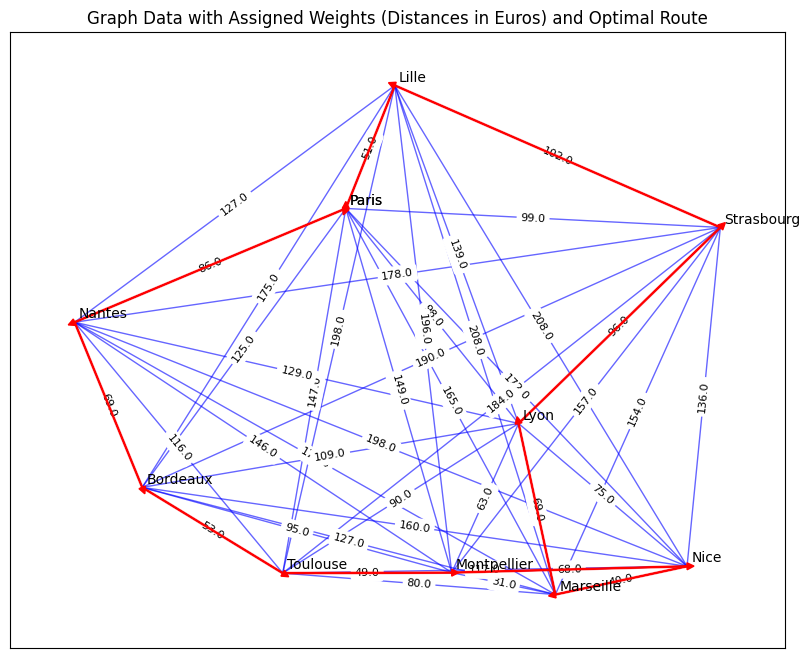

In [ ]:
# Convert the problem to finding a Hamiltonian cycle starting and ending at the specified start point
start_point = 'Paris'
# Add the start point to the city_data dictionary
start_lat = city_data['lat'][city_data['city'].index(start_point)]
start_lng = city_data['lng'][city_data['city'].index(start_point)]
city_data['city'].append(start_point)
city_data['lat'].append(start_lat)
city_data['lng'].append(start_lng)
# Create a new node representing the start point
new_node_id = num_nodes
G.add_node(new_node_id, city=start_point)

# Connect the new node to all other nodes
for i in range(num_nodes):
    city = G.nodes[i]['city']
    coord = (city_data['lat'][city_data['city'].index(city)], city_data['lng'][city_data['city'].index(city)])
    distance_km = geodesic(coord, (start_lat, start_lng)).kilometers
    G.add_edge(new_node_id, i, weight=0.25 * distance_km)

# Find the Hamiltonian cycle starting and ending at the specified start point
optimal_route = list(nx.approximation.traveling_salesman_problem(G, cycle=True))

# Remove the added node representing the start point
optimal_route.remove(new_node_id)

# Rearrange the route to start from the specified start point
start_index = optimal_route.index(city_data['city'].index(start_point))
optimal_route = optimal_route[start_index+1:] + optimal_route[:start_index+1]


# Remove the added node representing the start point
G.remove_node(new_node_id)

# Rearrange the route to start from the specified start point
start_index = optimal_route.index(new_node_id)
optimal_route = optimal_route[start_index+1:] + optimal_route[:start_index+1]
# Create a GeoDataFrame for the optimal route
route_points = [(city_data['lng'][i], city_data['lat'][i]) for i in optimal_route]
gdf_route = gpd.GeoDataFrame({'geometry': [LineString(route_points + [route_points[0]])]})

# Set the positions of nodes using spring_layout
node_positions = nx.spring_layout(G, seed=42, iterations=100, scale=30)
# Plot the optimal route in red color with arrows
optimal_route_edges = [(optimal_route[i], optimal_route[i + 1]) for i in range(len(optimal_route) - 1)] + [(optimal_route[-1], optimal_route[0])]
optimal_route_positions = {node: node_positions[node-1] if node != 0 else (0, 0) for node in optimal_route}

# ... (same code as before)

# Create a plot for the graph data with assigned weights
fig, ax = plt.subplots(figsize=(10, 8))

# Create a GeoDataFrame for the cities with Point geometries
gdf_cities = gpd.GeoDataFrame(city_data, geometry=gpd.points_from_xy(city_data['lng'], city_data['lat']))

# Draw the routes as edges with weights as labels
edges = nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6, width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

# Add labels for the cities
for x, y, label in zip(gdf_cities.geometry.x, gdf_cities.geometry.y, gdf_cities['city']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='black', fontsize=10)

# Plot the optimal route in red color with arrows
for i in range(len(optimal_route) - 1):
    city1 = city_data['city'][optimal_route[i]]
    city2 = city_data['city'][optimal_route[i + 1]]
    x_coords = [city_data['lng'][optimal_route[i]], city_data['lng'][optimal_route[i + 1]]]
    y_coords = [city_data['lat'][optimal_route[i]], city_data['lat'][optimal_route[i + 1]]]
    ax.plot(x_coords, y_coords, color='red', linewidth=2, alpha=0.6, zorder=1)

    # Add arrows to the line segments
    dx = x_coords[1] - x_coords[0]
    dy = y_coords[1] - y_coords[0]
    ax.arrow(x_coords[0], y_coords[0], dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

# Connect the last city to the first city in the optimal route
city1 = city_data['city'][optimal_route[-1]]
city2 = city_data['city'][optimal_route[0]]
x_coords = [city_data['lng'][optimal_route[-1]], city_data['lng'][optimal_route[0]]]
y_coords = [city_data['lat'][optimal_route[-1]], city_data['lat'][optimal_route[0]]]
ax.plot(x_coords, y_coords, color='red', linewidth=2, alpha=0.6, zorder=1)

# Draw the cities as nodes on top of the edges
#nx.draw_networkx_nodes(G, pos, node_size=200, node_color='red', alpha=0.7, ax=ax)

# Set the axis limits to focus on the cities
ax.set_xlim(min(city_data['lng']) - 1, max(city_data['lng']) + 1)
ax.set_ylim(min(city_data['lat']) - 1, max(city_data['lat']) + 1)

# Show the plot
plt.title('Graph Data with Assigned Weights (Distances in Euros) and Optimal Route')
plt.axis('equal')
plt.show()


In [ ]:
city_data['city'][0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Paris'

In [ ]:
def route_to_string(optimal_route):

    route_string = "Start at " + city_data['city'][optimal_route[0]]
    for city in optimal_route[1:]:
        route_string += f" -> {city_data['city'][city]}"
    return route_string



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Example usage
print(route_to_string(optimal_route))

Start at Paris -> Lille -> Paris -> Nantes -> Nice -> Montpellier -> Toulouse -> Paris -> Strasbourg -> Lyon -> Bordeaux -> Marseille -> Paris


In [ ]:
import random
# Add random positive cost to each edge
for edge in G.edges():
    G[edge[0]][edge[1]]['cost'] =  random.randint(25, 200)  # Assign random cost (25 to 100) to each edge

# Define a custom weight function that considers both distance and cost
def custom_weight(u, v, data):
    distance_weight = data['weight']  # Distance weight (previously calculated)
    cost_weight = data['cost']  # Custom cost weight for the edge
    return distance_weight + cost_weight

# Compute the shortest path with the custom weight function
optimal_route = nx.approximation.traveling_salesman_problem(G, cycle=True, weight=custom_weight)


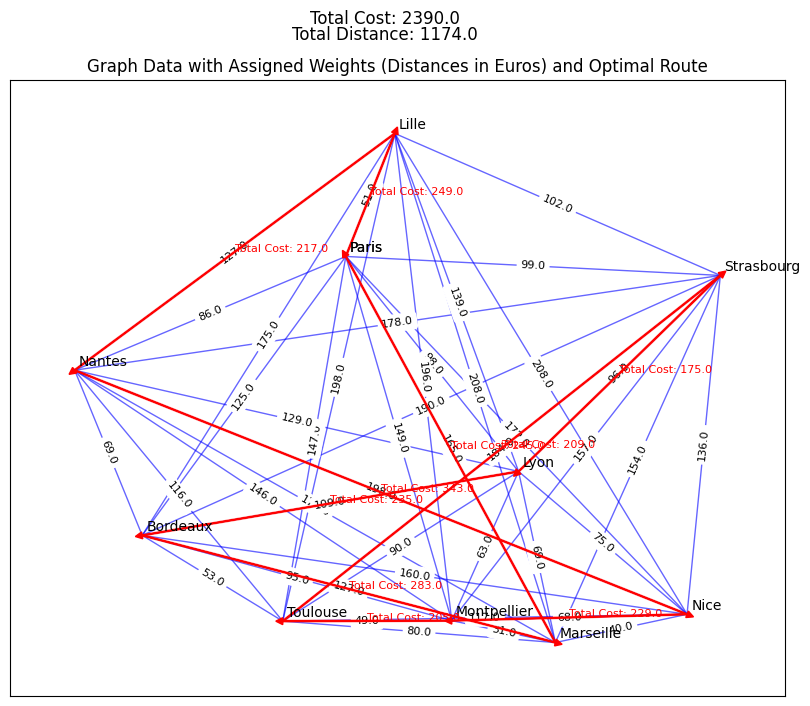

In [ ]:
# Create a GeoDataFrame for the optimal route
route_points = [(city_data['lng'][i], city_data['lat'][i]) for i in optimal_route]
gdf_route = gpd.GeoDataFrame({'geometry': [LineString(route_points + [route_points[0]])]})

# Set the positions of nodes using spring_layout
node_positions = nx.spring_layout(G, seed=42, iterations=100, scale=30)

# Plot the optimal route in red color with arrows
optimal_route_edges = [(optimal_route[i], optimal_route[i + 1]) for i in range(len(optimal_route) - 1)] + [(optimal_route[-1], optimal_route[0])]
optimal_route_positions = {node: node_positions[node-1] if node != 0 else (0, 0) for node in optimal_route}
# Create a plot for the graph data with assigned weights
fig, ax = plt.subplots(figsize=(10, 8))
# Create a GeoDataFrame for the cities with Point geometries
gdf_cities = gpd.GeoDataFrame(city_data, geometry=gpd.points_from_xy(city_data['lng'], city_data['lat']))
# Draw the routes as edges with weights as labels
edges = nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6, width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
# Calculate the total cost for the optimal route
total_cost = sum(G[optimal_route[i]][optimal_route[i + 1]]['cost'] for i in range(len(optimal_route) - 1)) + sum(G[optimal_route[i]][optimal_route[i + 1]]['weight'] for i in range(len(optimal_route) - 1))
total_distance = sum(G[optimal_route[i]][optimal_route[i + 1]]['weight'] for i in range(len(optimal_route) - 1))
# Add labels for the cities
for x, y, label in zip(gdf_cities.geometry.x, gdf_cities.geometry.y, gdf_cities['city']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='black', fontsize=10)

# Plot the optimal route in red color with arrows and cost labels
for i in range(len(optimal_route) - 1):
    city_index1 = optimal_route[i]
    city_index2 = optimal_route[i + 1]
    city1 = city_data['city'][city_index1]
    city2 = city_data['city'][city_index2]
    x_coords = [city_data['lng'][city_index1], city_data['lng'][city_index2]]
    y_coords = [city_data['lat'][city_index1], city_data['lat'][city_index2]]
    cost = G[city_index1][city_index2]['cost'] + G[city_index1][city_index2]['weight']
    ax.plot(x_coords, y_coords, color='red', linewidth=2, alpha=0.6, zorder=1)
    ax.annotate(f'Total Cost: {cost}', xy=(sum(x_coords) / 2, sum(y_coords) / 2), color='red', fontsize=8)
    # Add arrows to the line segments
    dx = x_coords[1] - x_coords[0]
    dy = y_coords[1] - y_coords[0]
    ax.arrow(x_coords[0], y_coords[0], dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

# Connect the last city to the first city in the optimal route
city1 = city_data['city'][optimal_route[-1]]
city2 = city_data['city'][optimal_route[0]]
x_coords = [city_data['lng'][optimal_route[-1]], city_data['lng'][optimal_route[0]]]
y_coords = [city_data['lat'][optimal_route[-1]], city_data['lat'][optimal_route[0]]]
ax.plot(x_coords, y_coords, color='red', linewidth=2, alpha=0.6, zorder=1)

# Draw the cities as nodes on top of the edges
#nx.draw_networkx_nodes(G, pos, node_size=200, node_color='red', alpha=0.7, ax=ax)

# Set the axis limits to focus on the cities
ax.set_xlim(min(city_data['lng']) - 1, max(city_data['lng']) + 1)
ax.set_ylim(min(city_data['lat']) - 1, max(city_data['lat']) + 1)

# Show the plot
plt.title('Graph Data with Assigned Weights (Distances in Euros) and Optimal Route')
plt.axis('equal')
plt.text(0.5, 0.95, f'Total Cost: {total_cost}', transform=fig.transFigure, fontsize=12, ha='center')
plt.text(0.5, 0.93, f'Total Distance: {total_distance}', transform=fig.transFigure, fontsize=12, ha='center')
plt.show()

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import DummyVecEnv
import gym
from gym import spaces
# Define the RL environment as a wrapper for the TSPEnvironment
class TSPGymEnv(gym.Env):
    def __init__(self, G):
        self.G = G
        self.num_nodes = G.number_of_nodes()
        self.reset()

        # Action space
        self.action_space = spaces.Discrete(self.num_nodes)

        # Observation space (current city)
        self.observation_space = spaces.Discrete(self.num_nodes)
        # Initialize the set of visited cities
        self.visited_cities = set()

        # Initialize the starting city as the current city
        self.current_city = 0
    def reset(self):
        self.visited_cities = set()
        self.current_city = random.choice(list(self.G.nodes()))
        self.visited_cities.add(self.current_city)
        return self.current_city



    def step(self, action):
        if self.current_city not in self.visited_cities:
            # Add the current city to the set of visited cities
            self.visited_cities.add(self.current_city)

        next_city = list(self.G[self.current_city])[action - 1 if action != 0 else 0]
        reward = -self.G[self.current_city][next_city]['cost']  # Negative cost as the reward
        done = len(self.visited_cities) == self.num_nodes
        if not done:
            self.current_city = next_city
        return next_city, reward, done, {}


# Create the RL environment
env = DummyVecEnv([lambda: TSPGymEnv(G)])


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# Create the DQN model
model = DQN("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=30000)


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10954    |
|    time_elapsed     | 0        |
|    total_timesteps  | 103      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9796     |
|    time_elapsed     | 0        |
|    total_timesteps  | 250      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 8789     |
|    time_elapsed     | 0        |
|    total_timesteps  | 345      |
----------------------------------
----------------------------------
| r

In [ ]:
# Create a list to store the optimal route
optimal_route = [0]

# Continue predicting the next cities until all cities have been visited
while len(optimal_route) < num_nodes:
    # Convert the current_city to a numpy array
    current_city_array = np.array([current_city])

    # Predict the next action using the RL model
    action, _ = model.predict(current_city_array)

    # Get the next city based on the predicted action
    next_city = list(G[current_city])[action[0] - 1 if action[0] != 0 else 0]

    # If the next city has not been visited yet, add it to the optimal route
    if next_city not in optimal_route:
        optimal_route.append(next_city)

    # Update the current_city for the next iteration
    current_city = next_city


In [ ]:

print(route_to_string(optimal_route))

Start at Paris -> Lyon -> Toulouse -> Bordeaux -> Lille -> Nice -> Strasbourg -> Nantes -> Marseille -> Montpellier


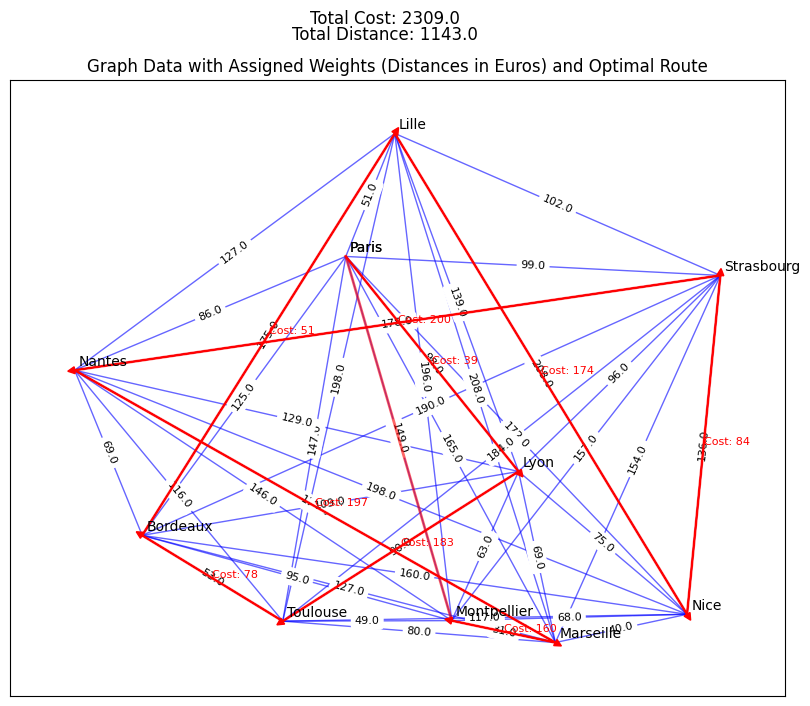

In [ ]:
# Create a GeoDataFrame for the optimal route
route_points = [(city_data['lng'][i], city_data['lat'][i]) for i in optimal_route]
gdf_route = gpd.GeoDataFrame({'geometry': [LineString(route_points + [route_points[0]])]})

# Set the positions of nodes using spring_layout
node_positions = nx.spring_layout(G, seed=42, iterations=100, scale=30)

# Plot the optimal route in red color with arrows
optimal_route_edges = [(optimal_route[i], optimal_route[i + 1]) for i in range(len(optimal_route) - 1)] + [(optimal_route[-1], optimal_route[0])]
optimal_route_positions = {node: node_positions[node-1] if node != 0 else (0, 0) for node in optimal_route}
# Create a plot for the graph data with assigned weights
fig, ax = plt.subplots(figsize=(10, 8))
# Create a GeoDataFrame for the cities with Point geometries
gdf_cities = gpd.GeoDataFrame(city_data, geometry=gpd.points_from_xy(city_data['lng'], city_data['lat']))
# Draw the routes as edges with weights as labels
edges = nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6, width=1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
# Calculate the total cost for the optimal route
total_cost = sum(G[optimal_route[i]][optimal_route[i + 1]]['cost'] for i in range(len(optimal_route) - 1)) + sum(G[optimal_route[i]][optimal_route[i + 1]]['weight'] for i in range(len(optimal_route) - 1))
total_distance = sum(G[optimal_route[i]][optimal_route[i + 1]]['weight'] for i in range(len(optimal_route) - 1))
# Add labels for the cities
for x, y, label in zip(gdf_cities.geometry.x, gdf_cities.geometry.y, gdf_cities['city']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='black', fontsize=10)

# Plot the optimal route in red color with arrows and cost labels
for i in range(len(optimal_route) - 1):
    city_index1 = optimal_route[i]
    city_index2 = optimal_route[i + 1]
    city1 = city_data['city'][city_index1]
    city2 = city_data['city'][city_index2]
    x_coords = [city_data['lng'][city_index1], city_data['lng'][city_index2]]
    y_coords = [city_data['lat'][city_index1], city_data['lat'][city_index2]]
    cost = G[city_index1][city_index2]['cost']
    ax.plot(x_coords, y_coords, color='red', linewidth=2, alpha=0.6, zorder=1)
    ax.annotate(f'Cost: {cost}', xy=(sum(x_coords) / 2, sum(y_coords) / 2), color='red', fontsize=8)
    # Add arrows to the line segments
    dx = x_coords[1] - x_coords[0]
    dy = y_coords[1] - y_coords[0]
    ax.arrow(x_coords[0], y_coords[0], dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

# Connect the last city to the first city in the optimal route
city1 = city_data['city'][optimal_route[-1]]
city2 = city_data['city'][optimal_route[0]]
x_coords = [city_data['lng'][optimal_route[-1]], city_data['lng'][optimal_route[0]]]
y_coords = [city_data['lat'][optimal_route[-1]], city_data['lat'][optimal_route[0]]]
ax.plot(x_coords, y_coords, color='red', linewidth=2, alpha=0.6, zorder=1)

# Draw the cities as nodes on top of the edges
#nx.draw_networkx_nodes(G, pos, node_size=200, node_color='red', alpha=0.7, ax=ax)

# Set the axis limits to focus on the cities
ax.set_xlim(min(city_data['lng']) - 1, max(city_data['lng']) + 1)
ax.set_ylim(min(city_data['lat']) - 1, max(city_data['lat']) + 1)

# Show the plot
plt.title('Graph Data with Assigned Weights (Distances in Euros) and Optimal Route')
plt.axis('equal')
plt.text(0.5, 0.95, f'Total Cost: {total_cost}', transform=fig.transFigure, fontsize=12, ha='center')
plt.text(0.5, 0.93, f'Total Distance: {total_distance}', transform=fig.transFigure, fontsize=12, ha='center')
plt.show()

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# Set the number of nodes (cities) and maximum possible routes between two nodes
num_nodes = 10
max_routes = 3
required_flow = 1000  # Total flow across the graph

# Define the city data
city_data = {
    'city': ['Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice', 'Nantes', 'Montpellier', 'Strasbourg', 'Bordeaux', 'Lille'],
    'lat': [48.8567, 43.2964, 45.7600, 43.6045, 43.7034, 47.2181, 43.6119, 48.5833, 44.8400, 50.6278],
    'lng': [2.3522, 5.3700, 4.8400, 1.4440, 7.2663, -1.5528, 3.8772, 7.7458, -0.5800, 3.0583]
}

# Create a random graph with num_nodes nodes and random edges
G = nx.DiGraph()  # Convert to directed graph

# Add nodes to the graph with demand attributes
total_demand = 0
# Set the source node (Paris) demand to a negative value

for city in city_data['city']:
    if city_data['city'] != 'Paris':
      demand = random.randint(-required_flow, required_flow)
      G.add_node(city, demand=demand)
      total_demand += demand
    else:
     demand = -required_flow
     G.add_node(city, demand=demand)
     total_demand += demand
# Balance the total demand to sum to 0
G.nodes[city_data['city'][-1]]['demand'] -= total_demand


# Generate random edges between nodes
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if random.random() < 0.5:
            num_routes = random.randint(1, max_routes)
            for _ in range(num_routes):
                distance = random.randint(50, 500)  # Random distance between 50 to 500 km
                cost = random.randint(10, 100)  # Random cost between 10 to 100 Euros
                capacity = random.randint(100, 500)  # Random capacity between 100 to 500 units
                G.add_edge(city_data['city'][i], city_data['city'][j], distance=distance, cost=cost, capacity=capacity)
                G.add_edge(city_data['city'][j], city_data['city'][i], distance=distance, cost=cost, capacity=capacity)  # Reverse direction

# Solve the problem using Minimum Cost Flow algorithm with required flow constraint
flow_cost, flow_dict = nx.network_simplex(G)



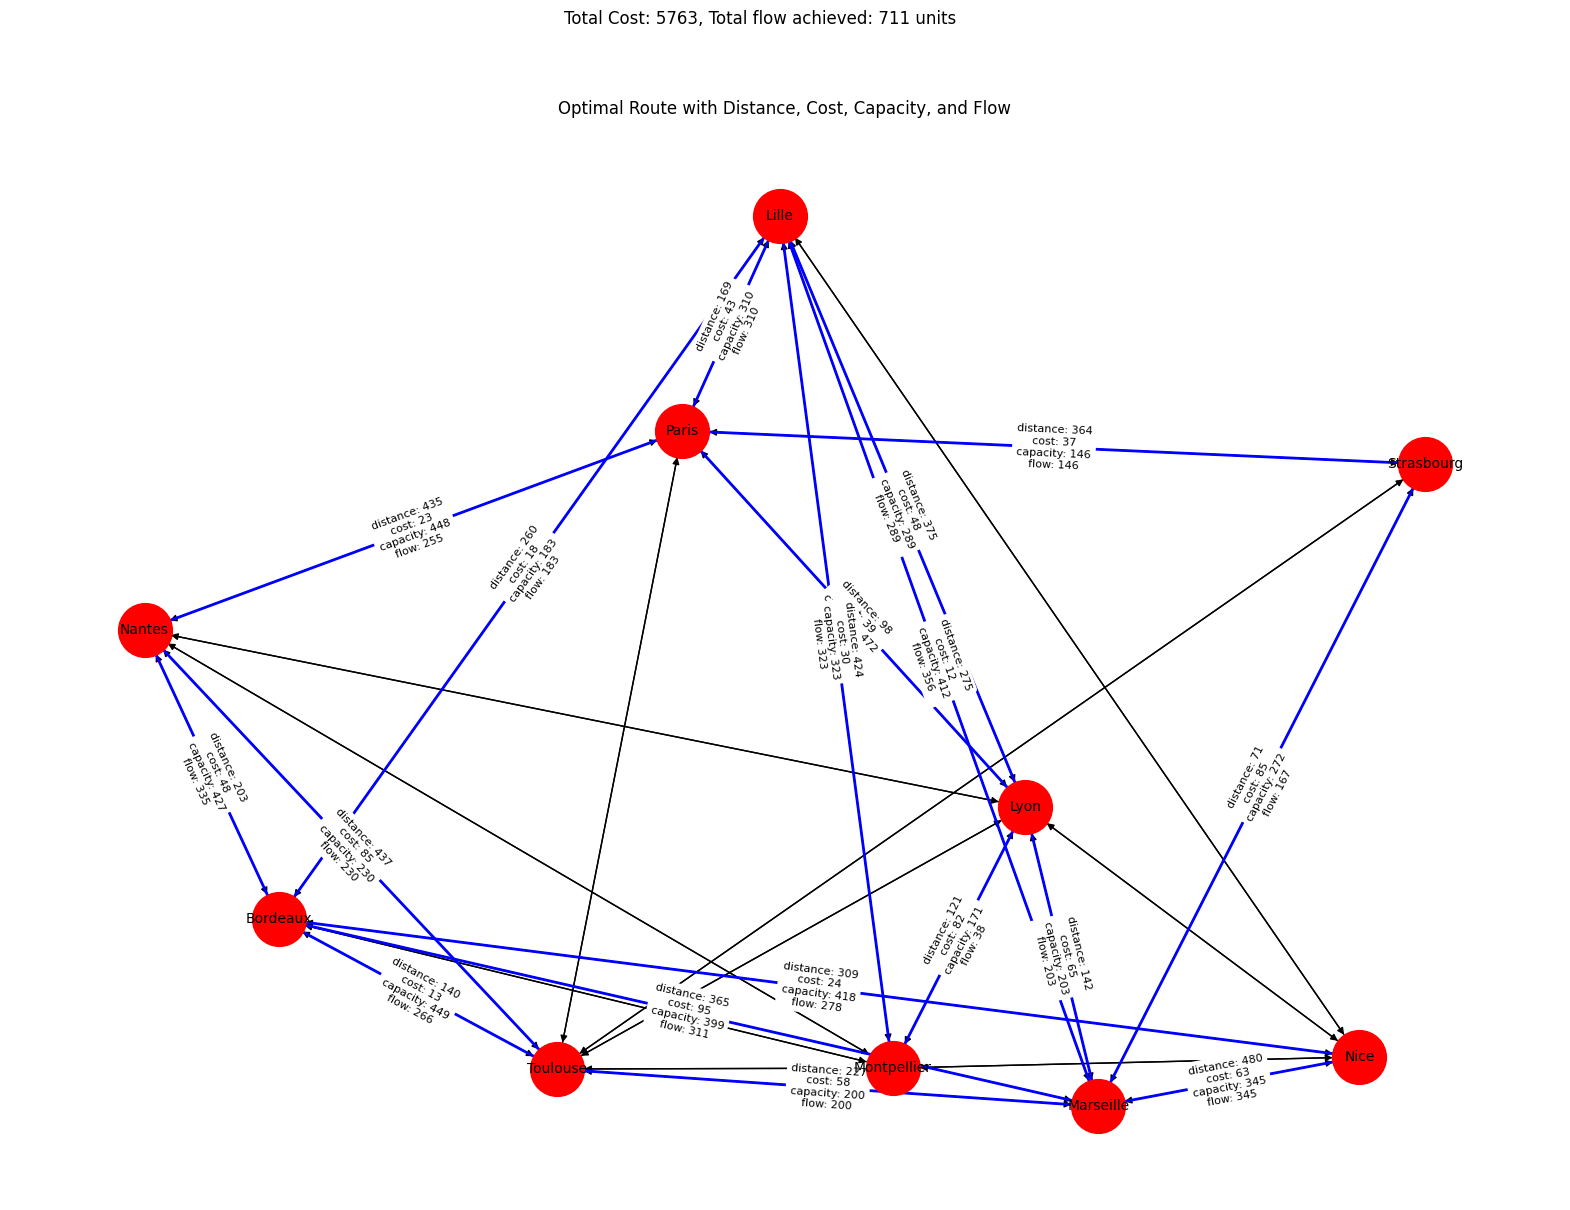

Optimal Route: [('Paris', 'Nantes'), ('Paris', 'Strasbourg'), ('Paris', 'Lille'), ('Marseille', 'Strasbourg'), ('Marseille', 'Lille'), ('Lyon', 'Paris'), ('Lyon', 'Marseille'), ('Lyon', 'Lille'), ('Toulouse', 'Marseille'), ('Toulouse', 'Bordeaux'), ('Nice', 'Marseille'), ('Nice', 'Bordeaux'), ('Nantes', 'Toulouse'), ('Nantes', 'Bordeaux'), ('Montpellier', 'Lyon'), ('Montpellier', 'Lille'), ('Bordeaux', 'Marseille'), ('Bordeaux', 'Lille')]
Total Distance: 4895 km
Total Cost: 5763 Euros
Total Capacity: 5697 units
Total flow achieved: 711 units


In [ ]:
# Get the optimal route and its attributes (distance, cost, capacity)
optimal_route = [(city, neighbor) for city, neighbors in flow_dict.items() for neighbor, flow in neighbors.items() if flow > 0]
total_distance = sum(G[edge[0]][edge[1]]['distance'] for edge in optimal_route)
total_cost = sum(G[edge[0]][edge[1]]['cost'] + G[edge[0]][edge[1]]['distance'] for edge in optimal_route)
total_capacity = sum(G[edge[0]][edge[1]]['capacity'] for edge in optimal_route)
total_flow = sum(flow for flow in flow_dict['Paris'].values())


# Visualization of the optimal route
fig, ax = plt.subplots(figsize=(20, 14))
pos = {city_data['city'][i]: (city_data['lng'][i], city_data['lat'][i]) for i in range(num_nodes)}
nx.draw(G, pos, with_labels=True, node_color='red', node_size=1500, font_size=10, ax=ax)
edges = nx.draw_networkx_edges(G, pos, edgelist=optimal_route, edge_color='blue', width=2, ax=ax)
edge_labels = {(u, v): f'distance: {G[u][v]["distance"]}\ncost: {G[u][v]["cost"]}\ncapacity: {G[u][v]["capacity"]}\nflow: {flow_dict[u][v]}'
               for u, v in G.edges() if (u, v) in optimal_route}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
plt.title('Optimal Route with Distance, Cost, Capacity, and Flow')
plt.text(0.5, 0.95, f'Total Cost: {total_cost}, Total flow achieved: {total_flow} units', transform=fig.transFigure, fontsize=12, ha='center')
plt.show()

# Print the results
print(f'Optimal Route: {optimal_route}')
print(f'Total Distance: {total_distance} km')
print(f'Total Cost: {total_cost} Euros')
print(f'Total Capacity: {total_capacity} units')
print(f'Total flow achieved: {total_flow} units')

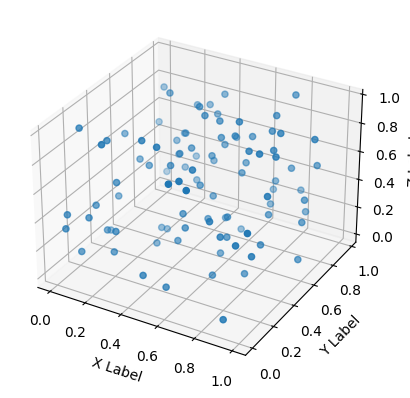

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a sample 3D array
x = np.random.rand(10, 10, 3)  # Replace with your 3D data

# Extract the coordinates for the scatter plot
x_coords, y_coords, z_coords = x[:, :, 0], x[:, :, 1], x[:, :, 2]

# Create the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()
